# Perpetual American example


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm, trange
from math import exp, sqrt, log
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import i0, i1, iv
from numpy import random
from torch.nn.functional import normalize
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.optimize as opt
import copy as copy

In [4]:
#from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter()

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.cuda.FloatTensor')
#device = torch.device("cpu")

In [6]:
class PDEQnet(nn.Module):
  def __init__(self, dim, width, beta):
    super(PDEQnet, self).__init__()
    self.dim = dim
    self.width = width
    self.innerwidth = int(width/2)
    self.beta = beta

    self.wb = nn.Linear(self.dim, self.innerwidth).to(device)
    self.wb2 = nn.Linear(self.innerwidth, self.width).to(device)
    self.c = nn.Linear(self.width, 1, bias=False).to(device)

  def forward(self, x):
    x = self.wb(x)
    x = torch.sigmoid(x)
    #x = 1/(1+torch.pow(x,2))
    x = self.wb2(x)
    x = torch.sigmoid(x)
    #x = 1/(1+torch.pow(x,2))
    x = self.c(x)
    return x

  def assign_value(self):
    self.c.weight.data = torch.as_tensor(np.random.uniform(-1, 1, size=self.c.weight.shape), dtype=torch.float32).to(device)
    self.wb.weight.data = torch.as_tensor(np.random.normal(0, 1, size=self.wb.weight.shape),  dtype=torch.float32).to(device)
    self.wb.bias.data = torch.as_tensor(np.random.normal(0, 1, size=self.wb.bias.shape) ,dtype=torch.float32).to(device)
    self.wb2.weight.data = torch.as_tensor(np.random.normal(0, 1, size=self.wb2.weight.shape),  dtype=torch.float32).to(device)
    self.wb2.bias.data = torch.as_tensor(np.random.normal(0, 1, size=self.wb2.bias.shape) ,dtype=torch.float32).to(device)


In [7]:
# Parameters
dim = 1
gamma = 0.05
sigma2_2 = (0.25**2)/2 #sigma^2/2
#d = [1 for i in range(dim)]
K=0.5


# Hyper parameters
N = 2**8
beta = 0.5+0.01
# Learning rate
initial_lr = 0.05 * N**(2*beta-1)

# Auxiliary functions
def eta(grid):
  res = grid*(1.-grid)
  return res



# Monte Carlo
Nmc_max = 2000
Nmc_initial = 500
Nbasepoints = int(1e7)
# Default type


In [8]:
#True solution (to give right boundary)
m = (-(gamma-sigma2_2) - sqrt((gamma-sigma2_2)**2 + 4*sigma2_2*gamma))/(2*sigma2_2)
Sstar = m*K/(m-1)
def Vtrue_scalar(s):
    if s>Sstar:
        return (K-Sstar)*(s/Sstar)**m
    else:
        return (K-s)
def Vtrue(s):
    return np.array([Vtrue_scalar(x) for x in s])

Rightval = Vtrue_scalar(1)

In [9]:
# Q fit, fixed grid
qnet= PDEQnet(dim, N, beta).to(device)
# initialization of PDEQnet paramters
qnet.assign_value()
qnet2 = copy.deepcopy(qnet)


In [10]:
#qnet.load_state_dict(torch.load('/content/6d, Q-learning, 30k epochs.pkl'))

In [11]:
# Create reservoir of points, so we don't have to sample every loop
#this is maybe the one thing that's worth doing on a GPU

#source = torch.randn(size=(Nbasepoints, dim))
#source = normalize(source, p=2.0) #Normalize to sphere
#radius = torch.rand(size = (Nbasepoints,1))
#radius = torch.pow(torch.rand(size = (Nbasepoints,1)),1/dim)
#source = radius*source #renormalize

source = torch.rand(size=(Nbasepoints,dim))


  0%|          | 0/10000 [00:00<?, ?it/s]

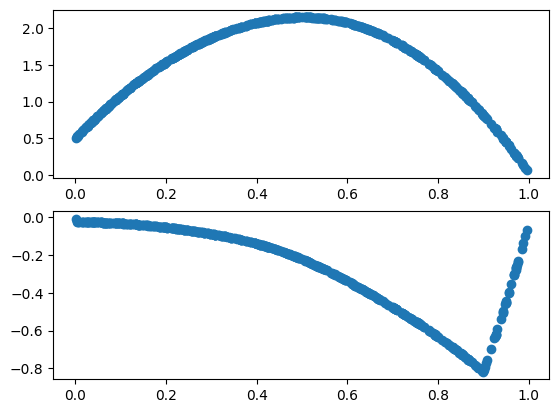

100%|██████████| 10000/10000 [02:45<00:00, 60.33it/s]


In [12]:
#Training algorithm, main
#torch.autograd.detect_anomaly()
# Num of epoch
Num_epo = 10000

# Loss level
loss_list = []

# Optmizer, scheduler
Qoptimizer = optim.RMSprop(qnet.parameters(), lr = initial_lr, alpha = 0.99, eps = 1e-08)
Qscheduler = LambdaLR(Qoptimizer, lr_lambda= lambda epoch: initial_lr/(1+(epoch/500)))

fig, axs = plt.subplots(2,1)

# Training
for count in trange(Num_epo):

  Nmc = int(Nmc_initial+(Nmc_max-Nmc_initial)*(1+count)/(1+Num_epo))
  epoch_sample = torch.randint(0,len(source), (Nmc,1))

  grid = source[epoch_sample].clone().detach()
  grid.requires_grad = True
  
  # Net output
  v = qnet(grid)
  v = v*eta(grid).reshape(v.shape) + (K-Rightval)*(1-grid)+Rightval # to give value of K at 0, 0 at 1


  # Tensor reshape
  v_r =  torch.reshape(v, (-1,))
  # Compute partial derivatives and the Laplacian
  dv_dx = torch.autograd.grad(v, grid, grad_outputs = torch.ones(grid.size()), create_graph = True)[0]
  d2v_dx2 = torch.autograd.grad(dv_dx, grid, grad_outputs = torch.ones(grid.size()), create_graph = True)[0]
  dv_dx = torch.reshape(dv_dx, (-1,))
  d2v_dx2 = torch.reshape(d2v_dx2, (-1,))
  
  #evaluate PDE operator
  lq = -gamma*v_r+ gamma*grid.reshape(-1)*dv_dx + torch.pow(grid.reshape(-1),2)*sigma2_2*d2v_dx2
  lq2 = torch.maximum((K-grid.reshape(-1)), torch.zeros_like(v_r)) - v_r
  #lq2 = K-grid.reshape(-1)-v_r
  lq = torch.maximum(lq, lq2)
  #LQ = lq.clone().detach()
  LQ=lq

  # Q-learning
  #loss_to_min =-1* torch.dot(LQ, v_r)
  loss_to_min = torch.dot(LQ, LQ)

  #with torch.cuda.stream(s):
  Qoptimizer.zero_grad()
  loss_to_min.backward()
  Qoptimizer.step()
  Qscheduler.step()

  loss = float(torch.dot(LQ, LQ))
  loss/= Nmc
  loss_list.append(loss)

  if count%20 == 0:
    axs[0].clear()
    axs[1].clear()
    axs[0].scatter(grid.detach().cpu(),v_r.detach().cpu())
    axs[1].scatter(grid.detach().cpu(), LQ.detach().cpu())
    plt.pause(0.01)



  0%|          | 0/10000 [00:00<?, ?it/s]

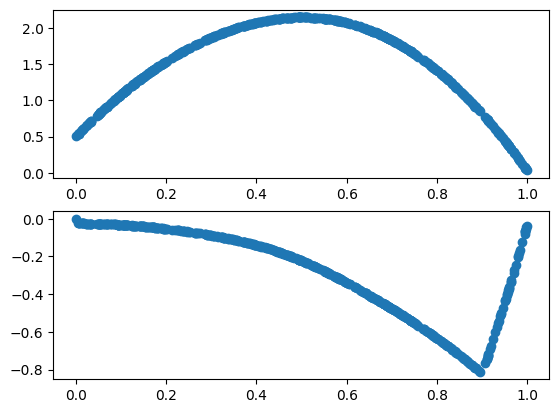

100%|██████████| 10000/10000 [01:52<00:00, 88.50it/s]


In [13]:
#Training algorithm, main
#torch.autograd.detect_anomaly()
# Num of epoch
Num_epo = 10000

# Loss level
loss_list2 = []

# Optmizer, scheduler
Qoptimizer = optim.RMSprop(qnet2.parameters(), lr = initial_lr, alpha = 0.99, eps = 1e-08)
Qscheduler = LambdaLR(Qoptimizer, lr_lambda= lambda epoch: initial_lr/(1+(epoch/500)))

fig, axs = plt.subplots(2,1)

# Training
for count in trange(Num_epo):

  Nmc = int(Nmc_initial+(Nmc_max-Nmc_initial)*(1+count)/(1+Num_epo))
  epoch_sample = torch.randint(0,len(source), (Nmc,1))

  grid = source[epoch_sample].clone().detach()
  grid.requires_grad = True
  
  # Net output
  v = qnet2(grid)
  v = v*eta(grid).reshape(v.shape) + (K-Rightval)*(1-grid)+Rightval # to give value of K at 0, 0 at 1


  # Tensor reshape
  v_r =  torch.reshape(v, (-1,))
  # Compute partial derivatives and the Laplacian
  dv_dx = torch.autograd.grad(v, grid, grad_outputs = torch.ones(grid.size()), create_graph = True)[0]
  d2v_dx2 = torch.autograd.grad(dv_dx, grid, grad_outputs = torch.ones(grid.size()), create_graph = True)[0]
  dv_dx = torch.reshape(dv_dx, (-1,))
  d2v_dx2 = torch.reshape(d2v_dx2, (-1,))
  
  #evaluate PDE operator
  lq = -gamma*v_r+ gamma*grid.reshape(-1)*dv_dx + torch.pow(grid.reshape(-1),2)*sigma2_2*d2v_dx2
  lq2 = torch.maximum((K-grid.reshape(-1)), torch.zeros_like(v_r)) - v_r
  #lq2 = K-grid.reshape(-1)-v_r
  lq = torch.maximum(lq, lq2)
  LQ = lq.clone().detach()
  #LQ=lq

  # Q-learning
  loss_to_min =-1* torch.dot(LQ, v_r)
  #loss_to_min = torch.dot(LQ, LQ)

  #with torch.cuda.stream(s):
  Qoptimizer.zero_grad()
  loss_to_min.backward()
  Qoptimizer.step()
  Qscheduler.step()

  loss = float(torch.dot(LQ, LQ))
  loss/= Nmc
  loss_list2.append(loss)

  if count%20 == 0:
    axs[0].clear()
    axs[1].clear()
    axs[0].scatter(grid.detach().cpu(),v_r.detach().cpu())
    axs[1].scatter(grid.detach().cpu(), LQ.detach().cpu())
    plt.pause(0.01)



In [14]:
#model_save_name = 'BM, 6d, 30k epochs.pkl'
#path = F"/content/{model_save_name}" 
#torch.save(qnet.state_dict(), path)

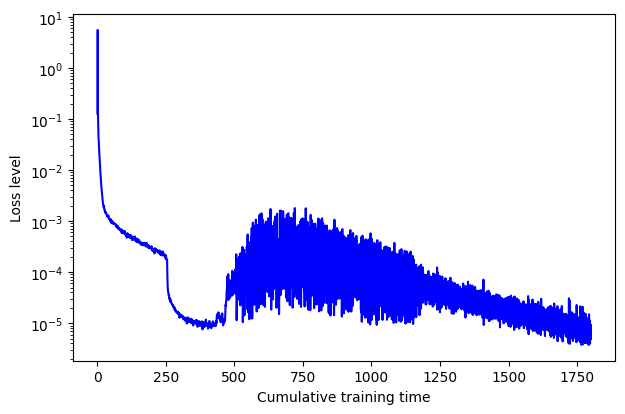

In [15]:
# Loss level
plt.figure(figsize=(7,4.5))
#ax = fig.add_subplot(1, 2, 1)
#axis=[i for i in range(Num_epo)]
axis = np.cumsum([1/(1+(i//500)) for i in range(len(loss_list))])
plt.xlabel('Cumulative training time')
plt.ylabel('Loss level')
plt.yscale('log') 
fig1 = plt.plot(axis,loss_list,'blue')

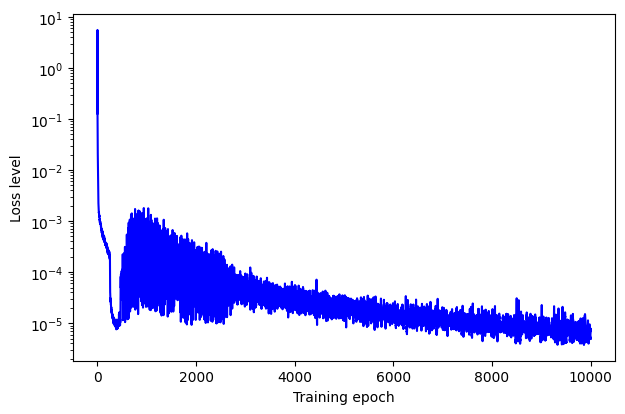

In [16]:
# Loss level
plt.figure(figsize=(7,4.5))
#ax = fig.add_subplot(1, 2, 1)
axis=[i for i in range(len(loss_list))]
plt.xlabel('Training epoch')
plt.ylabel('Loss level')
plt.yscale('log') 
fig1 = plt.plot(axis,loss_list,'blue')

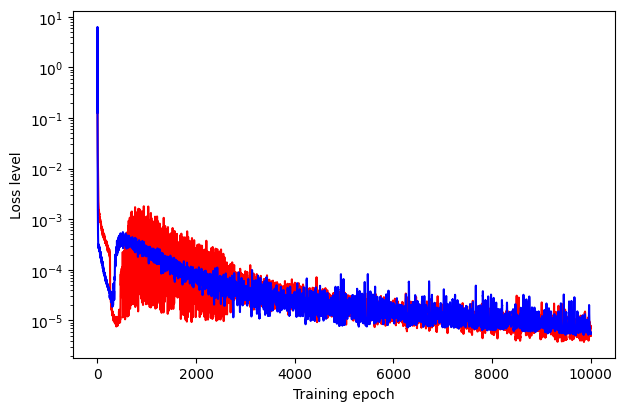

In [17]:
# Loss level
plt.figure(figsize=(7,4.5))
#ax = fig.add_subplot(1, 2, 1)
axis=[i for i in range(len(loss_list))]
plt.xlabel('Training epoch')
plt.ylabel('Loss level')
plt.yscale('log') 
plt.plot(axis,loss_list,'red')
plt.plot(axis,loss_list2,'blue')

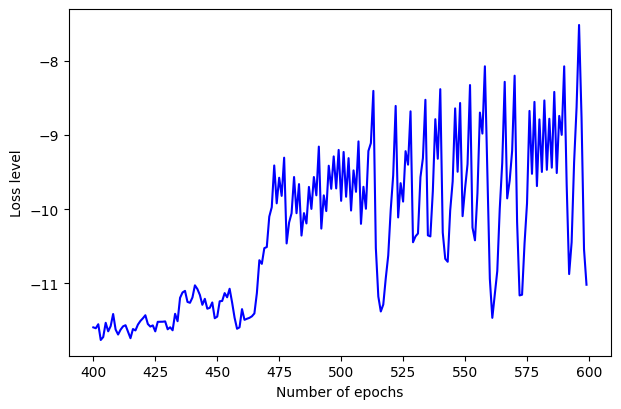

In [18]:
log_loss_list = [log(x) for x in loss_list]
plt.figure(figsize=(7,4.5))
#ax = fig.add_subplot(1, 2, 1)
axis=[i for i in range(Num_epo)]
plt.xlabel('Number of epochs')
plt.ylabel('Loss level')
fig1 = plt.plot(axis[400:600], log_loss_list[400:600],'blue')

/home/pengxy2024/miniconda3/envs/QPDE/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  # Remove the CWD from sys.path while we load stuff.
/home/pengxy2024/miniconda3/envs/QPDE/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we 

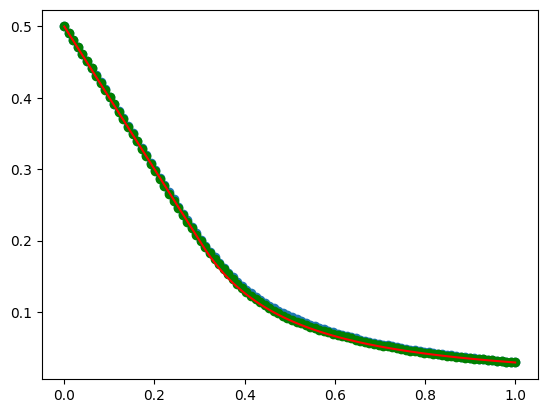

In [19]:
sgrid = torch.linspace(0,1,100).reshape(100,1)
v = qnet(sgrid)
v = v*eta(sgrid).reshape(v.shape) + (K-Rightval)*(1-sgrid)+Rightval # to give value of K at 0, 0 at 1
v2 = qnet2(sgrid)
v2 = v2*eta(sgrid).reshape(v2.shape) + (K-Rightval)*(1-sgrid)+Rightval # to give value of K at 0, 0 at 1
plt.scatter(sgrid.detach().cpu(), v.detach().cpu())
plt.scatter(sgrid.detach().cpu(), v2.detach().cpu(), color='green')
plt.plot(sgrid.detach().cpu(), Vtrue(sgrid.detach().cpu()), color='red')
